## Imgaug

imgaug is a library for image augmentation in machine learning experiments. It supports a wide range of augmentation techniques, allows to easily combine these and to execute them in random order or on multiple CPU cores, has a simple yet powerful stochastic interface and can not only augment images, but also keypoints/landmarks, bounding boxes, heatmaps and segmentation maps.

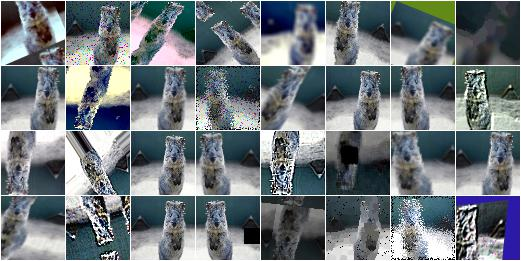

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imgaug as ia
import imgaug.augmenters as iaa


# Set ia seed
ia.seed(42)

### Load Test Image

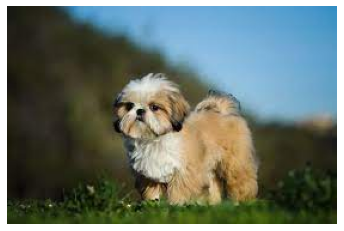

(182, 276, 3)


In [2]:
image = cv2.imread("../images/augmentation.jpg")

#Inver image channel BGR -> RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


plt.axis('off')
plt.imshow(image)
plt.show()

print(image.shape)

### Set Augmentations with ImgAug

In [7]:
# Rotação
rotate = iaa.Affine(rotate=(-25, 25))

# Flip
flip = iaa.Fliplr(1)

# Ruído Gaussiano
gaussian_noise = iaa.AdditiveGaussianNoise(scale=(10, 60))

# Crop
crop = iaa.Crop(percent=(0, 0.6))

# Sharpen
sharpen = iaa.Sharpen(alpha=(0, 1.0), lightness=(1.2, 1.5))

# Scale, Translação, Rotação e Corte
heavy_affine = iaa.Affine(
    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
    rotate=(-45, 45),
    shear=(-8, 8)
)

### Perform Augmentations

In [8]:
image_rotate = rotate.augment_images([image])
image_flip = flip.augment_images([image])
image_gaussian_noise = gaussian_noise.augment_images([image])
image_crop = crop.augment_images([image])
image_sharpen = sharpen.augment_images([image])
image_heavy_affine = heavy_affine.augment_images([image])

### Show Augmentations

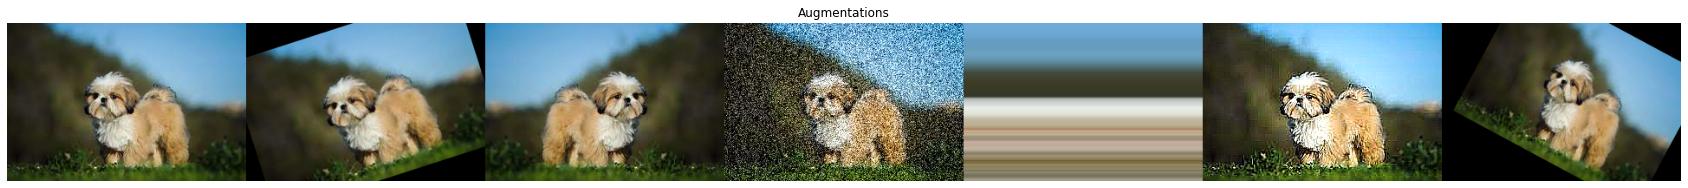

In [9]:
images_aug = [image,
              image_rotate[0],
              image_flip[0],
              image_gaussian_noise[0],
              image_crop[0],
              image_sharpen[0],
              image_heavy_affine[0]
              ]

# plot augmentation examples
plt.figure(figsize=(30, 20))
plt.title('Augmentations')
plt.axis('off')
plt.imshow(np.hstack(images_aug))
plt.show()

### Set Augmentation Pipeline

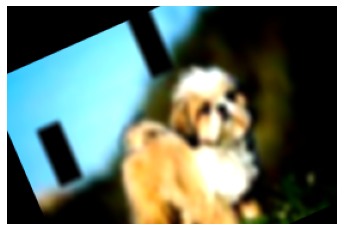

In [17]:
# Sometimes
sometimes = lambda aug: iaa.Sometimes(0.5, aug)


seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.1)),
    # Sometimes
    sometimes(iaa.GaussianBlur(sigma=(0, 0.5))),
    iaa.LinearContrast((0.75, 1.5)),
    # Some Of
    iaa.SomeOf((0, 5),
               [
                   # One Of
                   iaa.OneOf([
                       iaa.GaussianBlur((0, 3.0)),
                       iaa.AverageBlur(k=(2, 7)),
                       iaa.MedianBlur(k=(3, 11)),
                   ]),
                   iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
                   iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5),
                   iaa.OneOf([
                       iaa.Dropout((0.01, 0.1), per_channel=0.5),
                       iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                   ]),
                   iaa.Add((-10, 10), per_channel=0.5),
                   iaa.Multiply((0.5, 1.5)),
                   iaa.LinearContrast((0.5, 2.0), per_channel=0.5),
               ],
               random_order=True
               ),
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
],
random_order=True)


aug_image = seq.augment_image(image)

plt.axis('off')
plt.imshow(aug_image)
plt.show()

### Work with Bounding Box + Visualization Tool

52.43222372099692


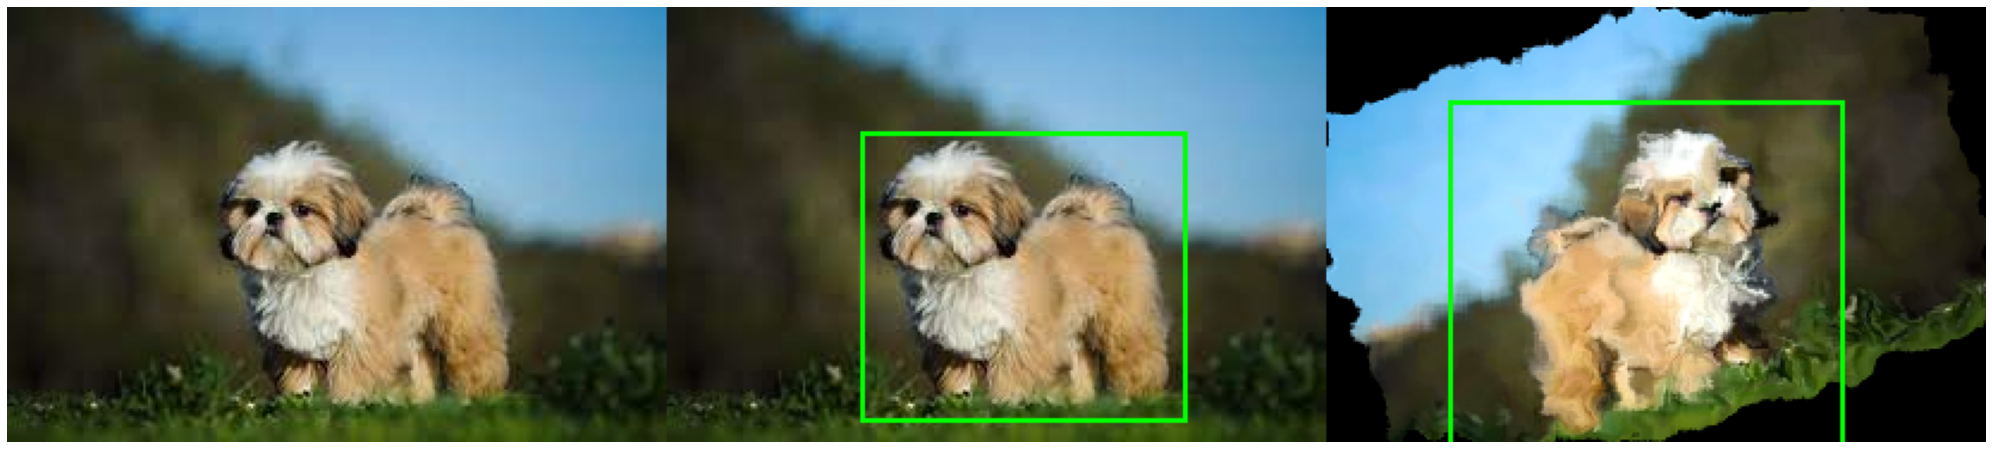

In [18]:
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage


bbs = BoundingBoxesOnImage([
    BoundingBox(x1=82, y1=53, x2=216, y2=172),
], shape=image.shape)

image_bb = bbs.draw_on_image(image, size=2)

# Set Light Augmentation
seq = iaa.Sequential([
    iaa.Fliplr(1),
    iaa.Multiply((1.1, 1.2)), 
    iaa.Affine(            
        scale=(0.8, 1.1),
        rotate=(-20, 20),        
    ),
    iaa.ElasticTransformation(alpha=50, sigma=5) 
])


# Augment BBs and images.
image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
image_aug = bbs_aug.draw_on_image(image_aug, size=2)
print(bbs_aug[0].x1)

plt.figure(figsize=(50, 8))
plt.axis('off')
plt.imshow(np.hstack([image, image_bb, image_aug]))
plt.show()

### Work with Segmentation Mask + Visualization Tool

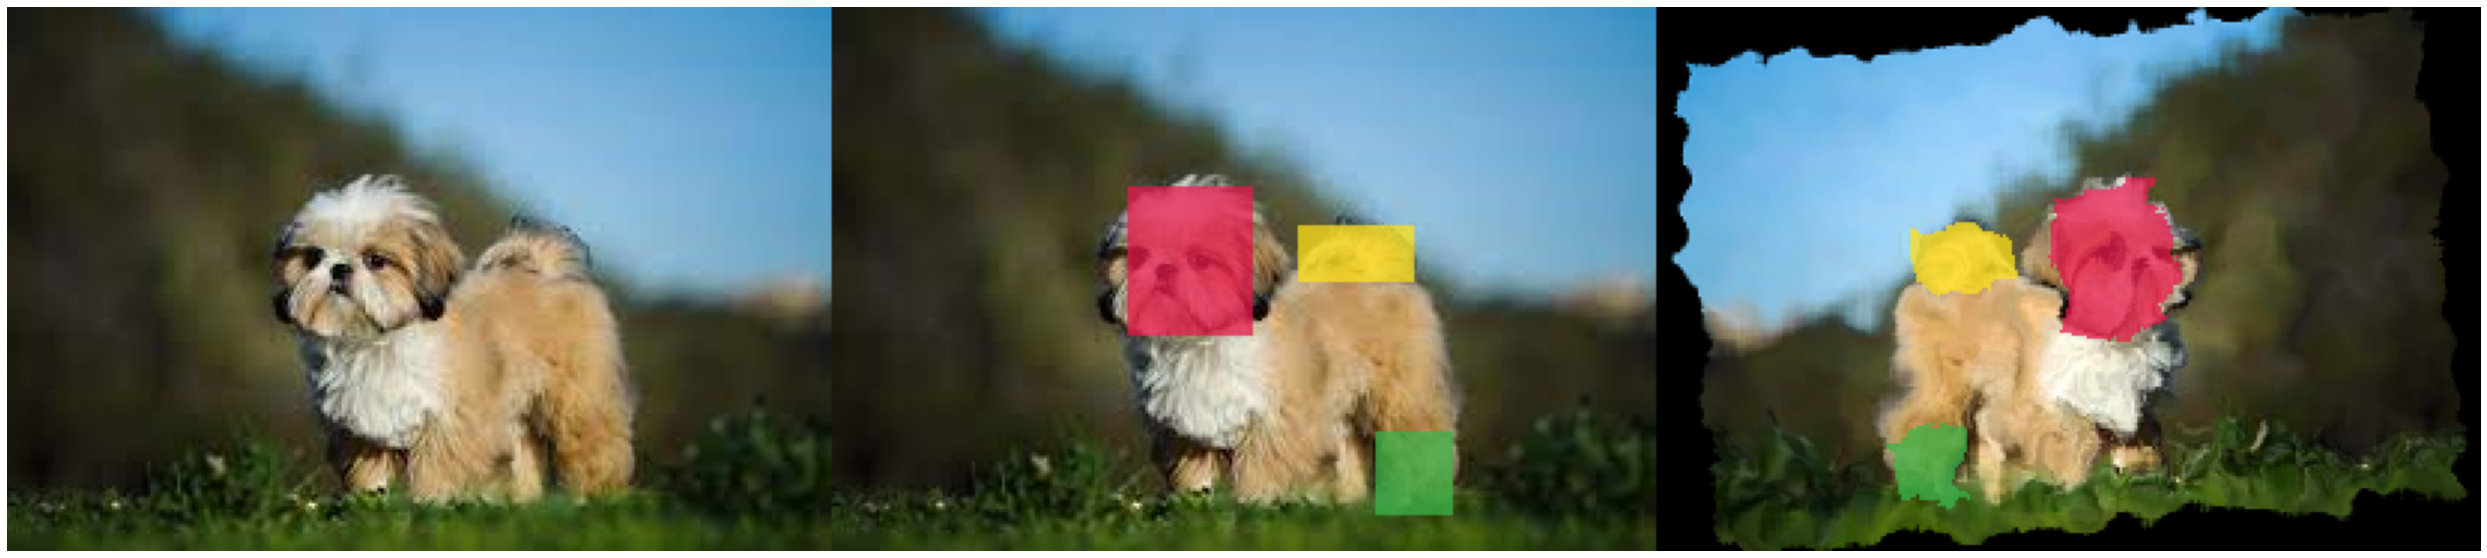

In [19]:
from imgaug.augmentables.segmaps import SegmentationMapsOnImage


segmap = np.zeros((image.shape[0], image.shape[1], 1), dtype=np.int32)
segmap[60:110, 99:141, 0] = 1
segmap[142:170, 182:208, 0] = 2
segmap[73:92, 156:195, 0] = 3
segmap = SegmentationMapsOnImage(segmap, shape=image.shape)
 
image_seg = segmap.draw_on_image(image)[0]

image_aug, segmap_aug = seq(image=image, segmentation_maps=segmap)
image_aug = segmap_aug.draw_on_image(image_aug)[0]
  

plt.figure(figsize=(50, 10))
plt.axis('off')
plt.imshow(np.hstack([image, image_seg, image_aug]))
plt.show()